<a href="https://colab.research.google.com/github/muralianamalatibco/pythonlearning/blob/main/CARS_CASESTUDY_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Business case Introduction

**Cars24** is one of the leading used-car buying and selling platform in India.

#### Current methodology to estimate the selling price has three major components
1. Past records of the "Selling Prices" of the same _Make_ and _Model_
2. Rule based calculations for the depreciation of the car
2. Rule based calculation for condition of the vehicle

As the **Pricing Data Scientist working at Cars24, you are given a task**

### GOAL: To automate the process of estimating price of the used car

## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!gdown 15tIjPrstV2RnOMv2VSIKW7yW_M3KjyNa

Downloading...
From: https://drive.google.com/uc?id=15tIjPrstV2RnOMv2VSIKW7yW_M3KjyNa
To: /content/cars24-car-price.csv
100% 1.79M/1.79M [00:00<00:00, 136MB/s]


### Overview

In [3]:
df = pd.read_csv('cars24-car-price.csv')
df.head()

,full_name,selling_price,year,seller_type,km_driven,fuel_type,transmission_type,mileage,engine,max_power,seats
0,Maruti Alto Std,1.20,2012.0,Individual,120000,Petrol,Manual,19.70,796.0,46.30,5.0
1,Hyundai Grand i10 Asta,5.50,2016.0,Individual,20000,Petrol,Manual,18.90,1197.0,82.00,5.0
2,Hyundai i20 Asta,2.15,2010.0,Individual,60000,Petrol,Manual,17.00,1197.0,80.00,5.0
3,Maruti Alto K10 2010-2014 VXI,2.26,2012.0,Individual,37000,Petrol,Manual,20.92,998.0,67.10,5.0
4,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,5.70,2015.0,Dealer,30000,Diesel,Manual,22.77,1498.0,98.59,5.0


Notice that Variable ```full_name``` contains both ```Maker``` and ```Model``` information - need to extract make and model from full_name.

In [4]:
df.shape

(19980, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19980 entries, 0 to 19979
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   full_name          19980 non-null  object 
 1   selling_price      19980 non-null  float64
 2   year               19980 non-null  float64
 3   seller_type        19980 non-null  object 
 4   km_driven          19980 non-null  int64  
 5   fuel_type          19980 non-null  object 
 6   transmission_type  19980 non-null  object 
 7   mileage            19980 non-null  float64
 8   engine             19980 non-null  float64
 9   max_power          19980 non-null  float64
 10  seats              19980 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.7+ MB


In [6]:
display(df.describe())

,selling_price,year,km_driven,mileage,engine,max_power,seats
count,19980.000000,19980.000000,1.998000e+04,19980.000000,19980.000000,19980.000000,19980.000000
mean,7.392066,2014.525125,5.824488e+04,19.347219,1476.327401,97.854443,5.317868
std,9.103088,3.249185,5.172509e+04,4.620053,520.449398,45.080670,0.835370
min,0.250000,1991.000000,1.000000e+02,0.000000,0.000000,5.000000,2.000000
25%,3.400000,2013.000000,3.116425e+04,16.800000,1197.000000,73.900000,5.000000
50%,5.200000,2015.000000,5.200000e+04,19.160000,1248.000000,86.700000,5.000000
75%,7.850000,2017.000000,7.400000e+04,22.320000,1582.000000,112.000000,5.000000
max,395.000000,2021.000000,3.800000e+06,120.000000,6752.000000,626.000000,14.000000


- `selling_price` ranges from [0.25, 395] - the values seem to be in lakhs.
- `mileage` min is 0, max is 120 - need to check for outliers.
- `engine` min is 0, max is 6752 - values appear to be in "cc" - need to check for outliers.

### Distributions

Lets check the distributions of these features one by one

<Axes: >

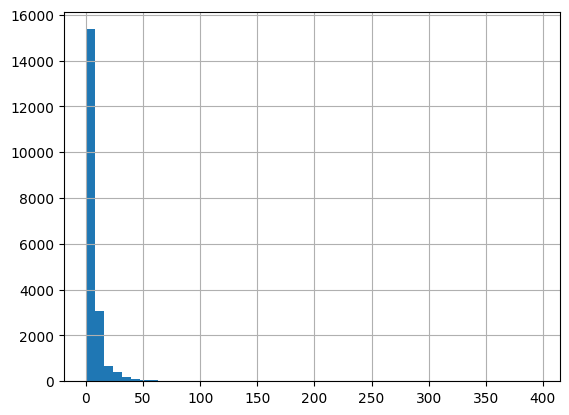

In [10]:
df['selling_price'].hist(bins=50)

Lets check the percntage of outliers. We are manually taking a call that price over a 100 (K) is an outlier by looking at the above plot

In [11]:
(df.loc[df.selling_price > 100].shape[0] / df.shape[0]) * 100

0.055055055055055056

Lets saturate selling price at **100**.

In [12]:
df.loc[df.selling_price > 100, 'selling_price'] = 100

> **INTERACTION**
> -  Can you think of an automated way of deciding this threshold 100 ? Seems like we made this decision arbitarily
> - **Hint:** use quantiles

### Outliers and Missing Values

#### Q: Which plot(s) is/are suitable for outlier visualisation ?

Similarly lets plot a histogram for **mileage**

<Axes: >

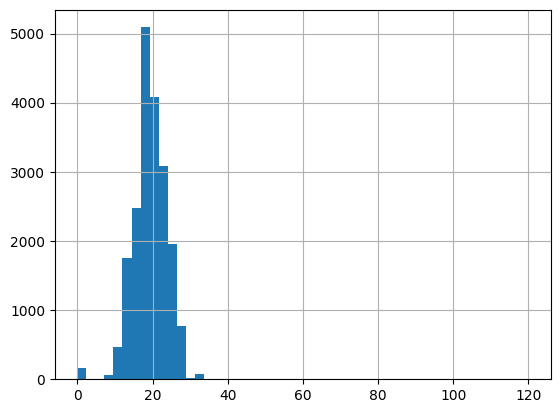

In [16]:
df['mileage'].hist(bins=50)

Another useful plot is called the 'density' plot. Which is also similar to histogram, but with a more *approximate* shape. It tries to fit a suitable distribution over the histogram and hence includes points that might not even be present in data at hand.

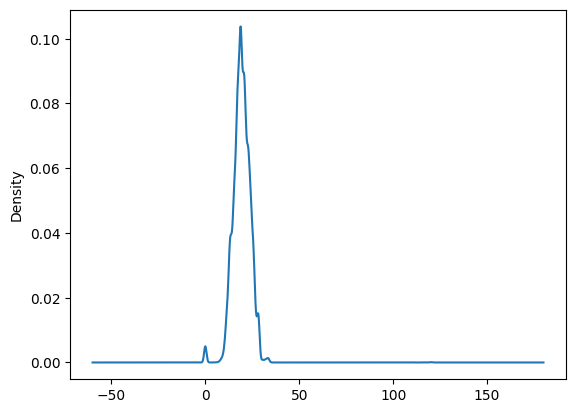

In [19]:
df["mileage"].plot(kind='kde');

We observe a skewed plot with right tail to long. An interesting point here would be mileage > 40, because after that it looks like the values mught just be outliers.

Above we saw that there was an unusual peak at **0**. Lets investigate further. Looking at points where mileage is less than 5

In [22]:
df[df['mileage'] <= 5].mileage.describe()

,mileage
count,161.000000
mean,0.024845
std,0.315244
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4.000000


Looks like we just have a number of points with mileage 0. That does not make much sense as it cannot be a real value for car mileage. Investigating mileage=0 cases

In [24]:
df.loc[df['mileage'] == 0].shape[0] / df.shape[0]

0.008008008008008008

In [26]:
df[df['mileage'] == 0].shape

(160, 11)